In [1]:
import os
import time
import numpy as np 
from numpy import log as ln
import pandas as pd 
from pandas import DataFrame
import pandas_datareader as dr
import datetime as dt 
from scipy import misc
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas_market_calendars as calen
from yahoo_fin import stock_info as si
from yahoo_fin import options

# Download Data and Calculate Implied Volatility

In [2]:
#download option data
#get the maturities
amzn_maturi = options.get_expiration_dates("amzn")
print(amzn_maturi)

['October 16, 2020', 'October 23, 2020', 'October 30, 2020', 'November 6, 2020', 'November 13, 2020', 'November 20, 2020', 'December 18, 2020', 'January 15, 2021', 'February 19, 2021', 'March 19, 2021', 'April 16, 2021', 'June 18, 2021', 'July 16, 2021', 'August 20, 2021', 'September 17, 2021', 'January 21, 2022', 'June 17, 2022', 'January 20, 2023']


In [3]:
# get three maturities
amzn_maturi=['November 13, 2020','December 18, 2020','January 15, 2021']

# get live price
amzn_live=si.get_live_price("amzn")
print('amzn live')
print(amzn_live)

# #download amzn option chian and save them to csv files separately

for date in amzn_maturi:
     call = options.get_calls("amzn",date)
     call.to_csv('amzn_call_'+date+'.csv')
     put = options.get_puts("amzn",date)
     put.to_csv('amzn_put_'+date+'.csv')


amzn live
3286.64990234375


In [4]:
# Federal funds (effective)
# r=1.58/100

In [5]:
#modify the forms
amzn_maturi=['November 13, 2020','December 18, 2020','January 15, 2021']
for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_'+date+'.csv')
        file['S0']=amzn_live      
        file['moneyness']='nan'
        file['aver_price']=0.0        
        file['cal_vol']=0.0
        file['BS']=0.0
        file['Bino_Euro']=0.0
        file['Bino_Ame']=0.0

        for i in file.index:
            
            file['aver_price'][i]=(file['Bid'][i]+file['Ask'][i])/2            
            if file['S0'][i]/file['Strike'][i]>=0.95 and file['S0'][i]/file['Strike'][i]<=1.05:
                file['moneyness'][i]='at the money'
        
        file=file[file['moneyness']=='at the money']                
        file.to_csv('amzn_'+type+'_ATM_'+date+'.csv',index=False)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
#Black-Scholes formulas

def bs_formula(S0,sig,T,K,r,option_type):
    
    d1=(ln(S0/K)+(r+(sig**2)/2)*T)/(sig*np.sqrt(T))
    d2=d1-(sig*np.sqrt(T))
    
    if option_type=='call':
        c=S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
        return c
    elif option_type=='put':
        p=K*np.exp(-r*T)*norm.cdf(-d2)-S0*norm.cdf(-d1)
        return p
    else:
        print('Error')

#bisection method
def f(x):
    return bs_formula(S0,x,T,K,r,option_type)-price

def bisection_method(a, b, tol):
    if f(a)*f(b)> 0:
        #end function, no root.
        print('No root found.')
    else:
        while (b - a)/2.0 > tol:
            midpoint = (a + b)/2.0
            if f(midpoint)== 0:
                return(midpoint) #The midpoint is the x-intercept/root.
            elif f(a)*f(midpoint)< 0: # Increasing but below 0 case
                b = midpoint
            else:
                a = midpoint
        
        return(midpoint)

In [7]:
#calculate implied volatility
nyse = calen.get_calendar('NYSE')

for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_ATM_'+date+'.csv')
   
        option_type=type
        schedule = nyse.schedule(start_date='2020-2-27', end_date=date)
        len(schedule)
        tol=10**(-6)
        T=len(schedule)/252
        r=1.58/100
        for i in file.index:
            S0=file['S0'][i]
            K=file['Strike'][i]
            price=file['aver_price'][i]            
            file['cal_vol'][i]=bisection_method(0.01, 1,tol)
            
        file.to_csv('amzn_'+type+'_ATM_'+date+'.csv',index=False)
         


/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

##  
Construct code to calculate option values using an additive binomial tree. For this part you need four versions: European and American as well as Call and Put. You may use the same tree construction (and function) for all options.

### Binomial General Additive European

In [8]:
def additiveBinomialEuro(K,T,S0,sig,r,N,option_type):
    # Equal jump size
    dt=T/N
    nu=r-0.5*sig**2
    dxu=np.sqrt(sig**2*dt+(nu*dt)**2)
    dxd=-dxu
    pu=0.5+0.5*(nu*dt/dxu)
    disc=np.exp(-r*dt)
    dpu=disc*pu
    dpd=disc*(1-pu)
    edxud=np.exp(dxu-dxd)
    edxd=np.exp(dxd)
    St=[0]*(N+1)
    C=[0]*(N+1)
    St[0]=S0*np.exp(N*dxd)

    for j in range(1,(N+1)):
        St[j]=St[j-1]*edxud
    
    if option_type=='call':
        sign=1
    elif option_type=='put':
        sign=-1
    else:
        print('Error')
        return
    
    for j in range(0,(N+1)):
            C[j] = max(0,sign*(St[j]-K))
    
    for i in range((N-1),-1,-1):
        for j in range(0,(i+1)):
            C[j]=dpu*C[j+1]+dpd*C[j]

    return (C[0])

### Binomial General Additive American

In [9]:
def additiveBinomialAmerican(K,T,S0,sig,r,N,option_type):
    # Equal jump size
    dt=T/N
    nu=r-0.5*sig**2
    dxu=np.sqrt(sig**2*dt+(nu*dt)**2)
    dxd=-dxu
    pu=0.5+0.5*(nu*dt/dxu)
    disc=np.exp(-r*dt)
    dpu=disc*pu
    dpd=disc*(1-pu)
    edxud=np.exp(dxu-dxd)
    edxd=np.exp(dxd)
    St=[0]*(N+1)
    C=[0]*(N+1)
    St[0]=S0*np.exp(N*dxd)

    for j in range(1,(N+1)):
        St[j]=St[j-1]*edxud
        
    if option_type=='call':
        sign=1
    elif option_type=='put':
        sign=-1
    else:
        print('wrong type')
        return
    
    for j in range(0,(N+1)):
            C[j] = max(0,sign*(St[j]-K))
    
    for i in range((N-1),-1,-1):
        for j in range(0,(i+1)):
            C[j]=dpu*C[j+1]+dpd*C[j]
            St[j]=St[j]/edxd
            C[j]=max(C[j],sign*(St[j]-K))

    return (C[0])

##  
Download Option prices. Calculate the option price (European Calls and Puts) using the binomial tree, and compare the results with the Black–Scholes price. Use at least 200 steps in your tree construction. Treat the options as American as well and plot these values side by side with the European and Black Scholes values. When you create the plot do not forget to plot the bid-ask values as well. 

From the downloaded data, select November 13th, 2020, December 18th, 2020, and January 15th, 2020. The time to maturity is one, two, and three months, and the strike price is close to the AMZN live price option. There are 20 options for call and put.

### calciulate the option price by binomial tree

In [10]:
nyse = calen.get_calendar('NYSE')
for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_ATM_'+date+'.csv')   
        option_type=type
        N=200 #steps
        schedule = nyse.schedule(start_date='2020-2-27', end_date=date)
        len(schedule)
        T=len(schedule)/252
        r=1.58/100
        for i in file.index:
            S0=file['S0'][i]
            K=file['Strike'][i]
            sig=file['cal_vol'][i]
            file['BS'][i]=bs_formula(S0,sig,T,K,r,option_type)
            file['Bino_Euro'][i]=additiveBinomialEuro(K,T,S0,sig,r,N,option_type)
            file['Bino_Ame'][i]=additiveBinomialAmerican(K,T,S0,sig,r,N,option_type)
            
        file.to_csv('amzn_'+type+'_ATM_'+date+'.csv',index=False)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [11]:
#report the result
amzn_maturi=['November 13, 2020','December 18, 2020','January 15, 2021']
for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_ATM_'+date+'.csv')
        file=file[0:20]
        file=file[['Contract Name','Strike','Bid','Ask','cal_vol','BS','Bino_Euro','Bino_Ame']]
        #get table
        file.to_csv('amzn_'+type+'_report_'+date+'.csv',index=False)
                

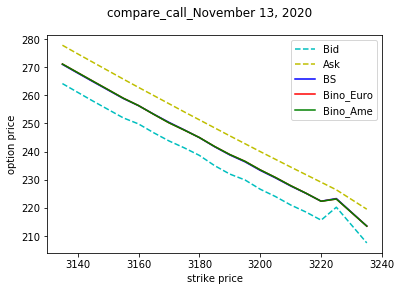

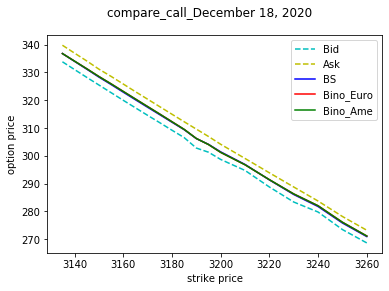

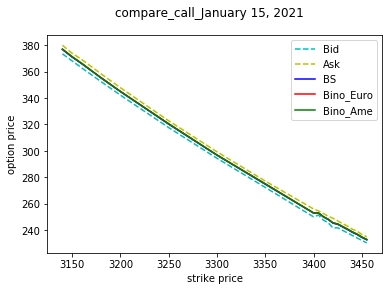

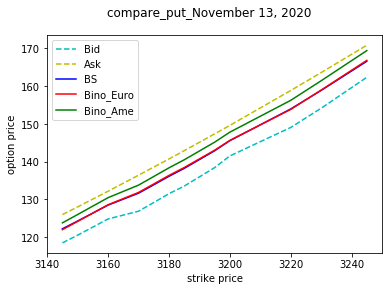

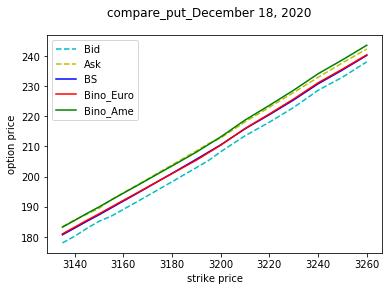

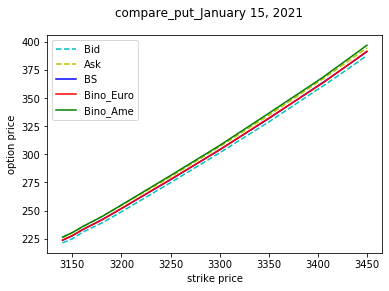

In [12]:
#plot

for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_report_'+date+'.csv')
        
        plt.plot(file['Strike'],file['Bid'],'--',color='c')
        plt.plot(file['Strike'],file['Ask'],'--',color='y')
        plt.plot(file['Strike'],file['BS'],'b')
        plt.plot(file['Strike'],file['Bino_Euro'],'r')
        plt.plot(file['Strike'],file['Bino_Ame'],'g')
        
        plt.legend(labels=['Bid','Ask','BS','Bino_Euro','Bino_Ame'])
        plt.xlabel('strike price')
        plt.ylabel('option price')
        plt.suptitle('compare_'+type+'_'+date)

        plt.show()

The data running result is in the zip file

## Comment of the table in the previous part

As is shown in the tables and graphs, the option prices computed by Black–Scholes, European binomial tree and American binomial tree are very close and they are all located between Bid-Ask prices.  

For call options, the European prices equal to American prices, because we don’t consider the dividends and it is never optimal to exercise an American call option on a non-dividend-paying stock prior to the option’s expiration. So, in this case, American call options are equivalent to European call options.  

For put options, American option prices are higher than European option prices, because under some circumstances the early exercise of an American put option on a non-dividend-paying stock is optimal.

##  
Consider N ∈ {10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400}. Compute and plot the absolute error for the European Put εN for as a function of N ∈ $N^∗$ the number of steps in the tree:
$$
\epsilon_N = | P^{BSM}(S_0,K,T,r;\sigma)-P^{BinomTree}_N(S_0,K,T,r;\sigma)\,
$$
where$P^{BSM}(S_0,K,T,r;\sigma)$and$P^{BinomTree}_N(S_0,K,T,r;\sigma)$are the Black-Scholes–Merton price and the price calculated using a binomial tree with N steps, respectively. What do you observe?

### Compute and plot the absolute error for the European Put

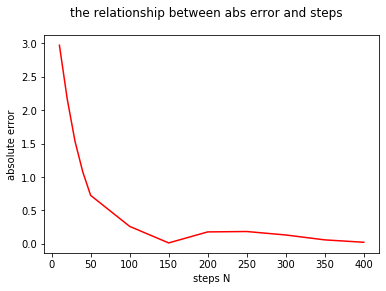

In [13]:
def error_Euro_P(N):
    return abs(bs_formula(S0,sig,T,K,r,'put')-additiveBinomialEuro(K,T,S0,sig,r,N,'put'))

#select a set of value to show
nyse = calen.get_calendar('NYSE')
schedule = nyse.schedule(start_date='2020-2-27', end_date='2020-10-09')
len(schedule)
T=len(schedule)/252
S0=1930.11
sig=0.32
K=1840
r=1.58/100

N_list=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]
error_list=[]

for N in N_list:
    error=error_Euro_P(N)
    error_list.append(error)

plt.plot(N_list,error_list,'r')

plt.xlabel('steps N')
plt.ylabel('absolute error')
plt.suptitle('the relationship between abs error and steps')
plt.show()    

# Problem 2: Implied Volatlity

Using the binomial tree for American Calls and Puts, calculate the implied volatility corresponding to the data you have downloaded in part (b). You will need to use the bisection or Newton/secant method of finding roots with the respective binomial trees. Compare these values of the implied volatility with the volatilities calculated using the usual Black Scholes formula (as in Homework 1). Write detailed observations.

## Bisection Method

In [14]:
def f(x):
    return additiveBinomialAmerican(K,T,S0,x,r,N,option_type)-price

def bisection_method(a, b, tol):
    if f(a)*f(b)> 0:
        #end function, no root.
        print('No root found')
    else:
        while (b - a)/2.0 > tol:
            midpoint = (a + b)/2.0
            if f(midpoint)== 0:
                return(midpoint) #The midpoint is the x-intercept/root.
            elif f(a)*f(midpoint)< 0: # Increasing but below 0 case
                b = midpoint
            else:
                a = midpoint
        
        return(midpoint)

In [15]:
nyse = calen.get_calendar('NYSE')
for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_ATM_'+date+'.csv')
        file=file[0:20]
        file['Bino_Ame_vol']=0.0
        option_type=type
        schedule = nyse.schedule(start_date='2020-2-27', end_date=date)
        len(schedule)
        tol=10**(-6)
        T=len(schedule)/252
        r=1.58/100
        N=200
        for i in file.index:
            S0=file['S0'][i]
            K=file['Strike'][i]
            price=file['aver_price'][i]            
            file['Bino_Ame_vol'][i]=bisection_method(0.01, 1,tol)
        
        file=file[['Contract Name','Strike','cal_vol','Bino_Ame_vol']]    
        file.to_csv('amzn_'+type+'_comparevol_'+date+'.csv',index=False)

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

## plot and compare

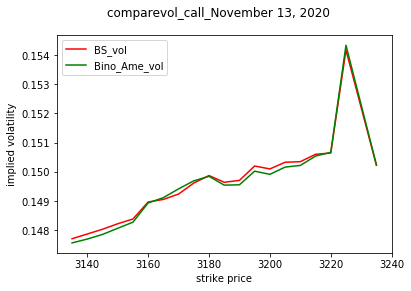

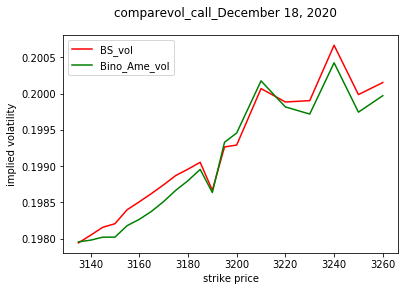

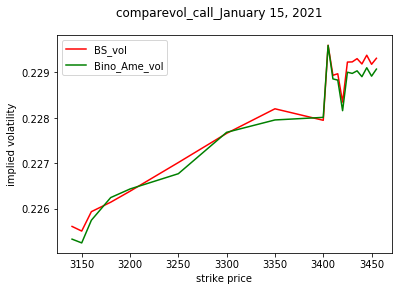

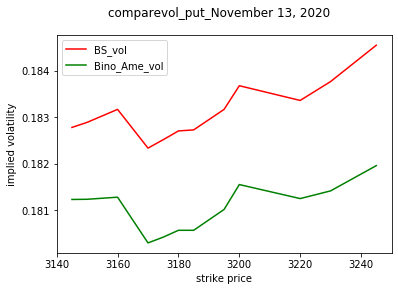

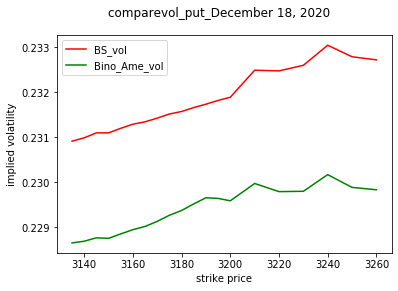

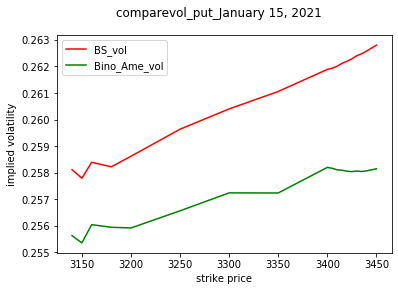

In [16]:
for type in ['call','put']:
    for date in amzn_maturi:
        file=pd.read_csv('amzn_'+type+'_comparevol_'+date+'.csv')
        plt.plot(file['Strike'],file['cal_vol'],'r')
        plt.plot(file['Strike'],file['Bino_Ame_vol'],'g')
        
        plt.legend(labels=['BS_vol','Bino_Ame_vol'])
        plt.xlabel('strike price')
        plt.ylabel('implied volatility')
        plt.suptitle('comparevol_'+type+'_'+date)

        plt.show()

# Problem 3

##  
Implement a trinomial tree to price European, American Call and Put options. 

### Trinomial European Option

In [17]:
def trinomial_European(K,T,S0,sig,r,div,N,option_type):
    dt=T/N
    dx=sig*np.sqrt(3*dt)
    nu=r-div-0.5*sig**2
    edx= np.exp(dx)
    pu=0.5*((sig**2*dt+nu**2*dt**2)/(dx**2)+nu*dt/dx)
    pd=0.5*((sig**2*dt+nu**2*dt**2)/(dx**2)-nu*dt/dx)
    pm =1-pu-pd
    disc= np.exp(-r*dt)
    St=np.zeros(shape=(N+1,2*N+1))
    C=np.zeros(shape=(N+1,2*N+1))
    
    for i in range(0,N+1):
        for j in range(0,(2*i+1)):
            St[i,j]=S0*edx**(i-j)

    if option_type==0:
        sign=1
    elif option_type==1:
        sign=-1
    else:
        print('Error')
        return
 
    for i in range(0,(N+1)):
        for j in range(0,(2*i+1)):
             C[i,j]=max(sign*(St[i,j]-K),0)

    for i in range(N-1,-1,-1):
        for j in range(0,2*N-1):  
            C[i,j]=disc*(pu*C[i+1,j]+pm*C[i+1,j+1]+pd*C[i+1,j+2])

    return C[0,0]

### Trinomial American Option

In [18]:
def trinomial_American(K,T,S0,sig,r,div,N,option_type):
    dt=T/N
    dx=sig*np.sqrt(3*dt)
    nu=r-div-0.5*sig**2
    edx= np.exp(dx)
    pu=0.5*((sig**2*dt+nu**2*dt**2)/(dx**2)+nu*dt/dx)
    pd=0.5*((sig**2*dt+nu**2*dt**2)/(dx**2)-nu*dt/dx)
    pm =1-pu-pd
    disc= np.exp(-r*dt)
    St=np.zeros(shape=(N+1,2*N+1))
    C=np.zeros(shape=(N+1,2*N+1))
    
    for i in range(0,N+1):
        for j in range(0,(2*i+1)):
            St[i,j]=S0*edx**(i-j)

    if option_type==0:
        sign=1
    elif option_type==1:
        sign=-1
    else:
        print('Error')
        return
 
    for i in range(0,(N+1)):
        for j in range(0,(2*i+1)):
             C[i,j]=max(sign*(St[i,j]-K),0)

    for i in range(N-1,-1,-1):
        for j in range(0,2*N-1):  
            C[i,j]=max(disc*(pu*C[i+1,j]+pm*C[i+1,j+1]+pd*C[i+1,j+2]),sign*(St[i,j]-K))

    return C[0,0]

##  
Consider $S_0 = 100, K = 100, T = 1 year, \sigma = 20\%, r = 5\%,\delta = 0.02.$Repeat the methods in problem 1 b) to d) with these parameters. Use at least N = 200 time steps and you do not need to download data. Create a table containing all results and comment.

### Black-Scholes formulas when considering dividends

In [19]:
def bs_formula(S0,sig,T,K,r,div,option_type):
    
    d1=(ln(S0/K)+(r-div+(sig**2)/2)*T)/(sig*np.sqrt(T))
    d2=d1-(sig*np.sqrt(T))
    
    if option_type==0:
        c=S0*np.exp(-div*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
        return c
    elif option_type==1:
        p=K*np.exp(-r*T)*norm.cdf(-d2)-S0*np.exp(-div*T)*norm.cdf(-d1)
        return p
    else:
        print("Error")

In [20]:
if __name__ == "__main__":
    K = 100
    S0 = 100
    T = 1
    sig = 0.2
    r = 0.05
    div = 0.02
    N = 500  
    BS = []
    European = []
    American = []
    bs_call = bs_formula(S0,sig,T,K,r,div,0)
    bs_put = bs_formula(S0,sig,T,K,r,div,1)
    euro_call = trinomial_European(K,T,S0,sig,r,div,N,0)
    euro_put = trinomial_European(K,T,S0,sig,r,div,N,1)
    american_call = trinomial_American(K,T,S0,sig,r,div,N,0)
    american_put = trinomial_American(K,T,S0,sig,r,div,N,1)
    BS.append(bs_call)
    European.append(euro_call)
    American.append(american_call)
    BS.append(bs_put)
    European.append(euro_put)
    American.append(american_put)
    option_types = ['call','put']
    d = {'option_type':option_types,'BS':BS,'Euro':European,'AMER':American}
    d = pd.DataFrame(data=d)
    print(d)

  option_type        BS      Euro      AMER
0        call  9.227006  9.223214  9.223214
1         put  6.330081  6.326289  6.657063


As is shown in the table, the option prices calculated by European trinomial tree are very close to that of BS formula. Besides, with dividends, both American call and put options prices are higher than that of European options, which is because that it could be better to exercise American options before expiration on a dividend-paying stock.

In [21]:
def error_triEuro_P(N):
    return abs(bs_formula(S0,sig,T,K,r,div,1)-trinomial_European(K,T,S0,sig,r,div,N,1))

In [22]:
if __name__ == "__main__":
    K=100
    S0=100
    T=1
    sig=0.2
    r=0.05
    div=0.02
    N_list=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]
    error_list=[]

    for N in N_list:
        error=error_triEuro_P(N)
        error_list.append(error)

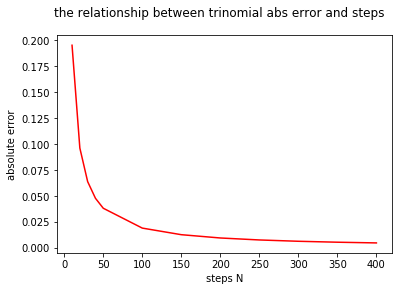

In [23]:
plt.plot(N_list,error_list,'r')
plt.xlabel('steps N')
plt.ylabel('absolute error')
plt.suptitle('the relationship between trinomial abs error and steps')
plt.show() 

# Problem 4: Pricing Exotic Options

##  
Construct a binomial tree to calculate the price of an European Up-and-Out call option. Use $S_0 = 10$, strike $K = 10$, maturity $T = 0.3$, volatility $\sigma = 0.2$, short rate $r = 0.01$, dividends $\delta = 0$, and barrier $H = 11$. Use as many steps in your tree as you think are necessary.

In [24]:
def Bino_Euro_Up_Out_Call(K,T,S0,sig,r,H,N):
    # Equal jump size 
    dt=T/N
    nu=r-0.5*sig**2
    dxu=np.sqrt(sig**2*dt+(nu*dt)**2)
    dxd=-dxu
    pu=0.5+0.5*(nu*dt/dxu)
    disc=np.exp(-r*dt)
    dpu=disc*pu
    dpd=disc*(1-pu)
    edxud=np.exp(dxu-dxd)
    edxd=np.exp(dxd)
    St=[0]*(N+1)
    C=[0]*(N+1)
    
    St[0]=S0*np.exp(N*dxd)
    
    for j in range(1,(N+1)):
        St[j]=St[j-1]*edxud
    
    for j in range(0,(N+1)):
        if St[j]<H:
            C[j] = max(0,St[j]-K)
        else:
            C[j]=0
                        
    for i in range((N-1),-1,-1):
        for j in range(0,(i+1)):           
            if St[j]<H:
                C[j]=dpu*C[j+1]+dpd*C[j]                                               
            else:
                C[j]=0

    return (C[0])

In [25]:
if __name__ == "__main__":
    S0=10
    K=10
    T=0.3
    sig=0.2
    r=0.01
    H=11
    N=400
    print(Bino_Euro_Up_Out_Call(K,T,S0,sig,r,H,N))

0.1336371505621503


##  
For the European Up-and-Out Call option explicit formulas exist. For example, implement the formula (5.2) from [2] and compare your results with part (a). Use the same parameters as before. Are your results matching?

In [26]:
def bs_formula(S0,sig,T,K,r,option_type):
    
    d1=(ln(S0/K)+(r+(sig**2)/2)*T)/(sig*np.sqrt(T))
    d2=d1-(sig*np.sqrt(T))
    
    if option_type==0:
        c=S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
        return c
    elif option_type==1:
        p=K*np.exp(-r*T)*norm.cdf(-d2)-S0*norm.cdf(-d1)
        return p
    else:
        print("Error")

In [27]:
def C_bs(S0,K):
    return bs_formula(S0,sig,T,K,r,0)

def P_bs(S0,K):
    return bs_formula(S0,sig,T,K,r,1)


def d_bs(S0,K):
    return (ln(S0/K)+nu*T)/(sig*np.sqrt(T))

In [28]:
# formula 5.2
def Up_Out_call_bs(K,T,S0,sig,r,H):
    return C_bs(S0,K)-C_bs(S0,H)-(H-K)*np.exp(-r*T)*norm.cdf(d_bs(S0,H))-(H/S0)**(2*nu/(sig**2))*(C_bs(H**2/S0,K)-C_bs(H**2/S0,H)-(H-K)*np.exp(-r*T)*norm.cdf(d_bs(H,S0)))

In [29]:
if __name__ == "__main__":
    S0=10
    K=10
    T=0.3
    sig=0.2
    r=0.01
    H=11
    N=400
    nu=r-0.5*sig**2

    print(Up_Out_call_bs(K,T,S0,sig,r,H))

0.05309279660325303


Analytical result: 0.05309279660325303  
Binomial result: 0.1336371505621503  
When comparing the results of binomial tree and analytical method, I find the results don’t match. I don’t think the binomial tree ideal for pricing barrier option. There might be some problems with its accuracy and simplicity of the tree structure.

##  
Price an European Up-and-In call option, using the same parameters as before. 

In [30]:
# formula 5.1
def Up_In_call_bs(K,T,S0,sig,r,H):
    return (H/S0)**(2*nu/(sig**2))*(P_bs(H**2/S0,K)-P_bs(H**2/S0,H)+(H-K)*np.exp(-r*T)*norm.cdf(-d_bs(H,S0)))+C_bs(S0,H)+(H-K)*np.exp(-r*T)*norm.cdf(d_bs(S0,H))

In [31]:
if __name__ == "__main__":
    I_by_parity=bs_formula(S0,sig,T,K,r,0)-Bino_Euro_Up_Out_Call(K,T,S0,sig,r,H,N)
    print(Up_In_call_bs(K,T,S0,sig,r,H))
    print(I_by_parity)

0.3981948482776454
0.31765049431874837


Show the result:  
Analytical method: 0.3981948482776454  
In-Out parity: 0.31765049431874837

## Calculate the price of an AMERICAN Up and In Put option

In [32]:
def American_U_I_P(K,T,S0,sig,r,H,N):
    # Equal jump size 
    dt=T/N
    nu=r-0.5*sig**2
    dxu=np.sqrt(sig**2*dt+(nu*dt)**2)
    dxd=-dxu
    pu=0.5+0.5*(nu*dt/dxu)
    disc=np.exp(-r*dt)
    dpu=disc*pu
    dpd=disc*(1-pu)
    edxud=np.exp(dxu-dxd)
    edxd=np.exp(dxd)
    St=[0]*(N+1)
    C=[0]*(N+1)
    
    St[0]=S0*np.exp(N*dxd)
    

    for j in range(1,(N+1)):
        St[j]=St[j-1]*edxud

    
    for j in range(0,(N+1)):
        if St[j]>H:
            C[j] = max(0,K-St[j])
        else:
            C[j]=0
                        
    for i in range((N-1),-1,-1):
        for j in range(0,(i+1)):
            St[j]=St[j]/edxd            
            if St[j]>H:
                C[j]=dpu*C[j+1]+dpd*C[j]                
                C[j]=max(C[j],K-St[j])                
            else:
                C[j]=0

    return (C[0])

In [33]:
if __name__ == "__main__":
    S0=10
    K=10
    T=0.3
    sig=0.2
    r=0.01
    H=11
    N=800
    print(American_U_I_P(K,T,S0,sig,r,H,N))

0
